In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ModuleNotFoundError: No module named 'requests'

##### Duomenų nuskaitymas vyksta per atskirą klasę. Į šį objektą nurdoma vietovės kodas, API URL. Ši klasė turi turėti du metodus:
#####     a Istorinių duomenų nuskaitymas už nurodytą laiko intervalą nuo - iki;
#####     b Prognozės duomenų nuskaitymas;
##### Abiem atvejais duomenys turėtų būti gražinami pandas. DataFrame  formatu, kur indeksas yra laikas (pd.DatetimeIndex) su įvertinta laiko zona;

In [42]:
# Klasė duomenų nuskaitymui iš API
class ReadData:
    # Inicializacija su API URL ir lokacijos kodu
    def __init__(self, apiUrl, locationCode):
        self.apiUrl = apiUrl
        self.locationCode = locationCode
        
    # Istorinių duomenų nuskaitymo nurodytu laikotarpiu metodas
    def getHistoricalData(self, startDate, endDate, stationCode):
        # Istorinių duomenų saugojimas
        allData = []
        # Pradžios datos konvertavimas į datetime formatą
        currentDate = pd.to_datetime(startDate)

        # Ciklas kiekvienai dienai nurodytu laikotarpiu
        while currentDate <= pd.to_datetime(endDate):
            # Formatuojama data
            dateStr = currentDate.strftime('%Y-%m-%d')
            # Sudaromas API užklausos URL
            endpoint = f"{self.apiUrl}stations/{stationCode}/observations/{dateStr}"
            # Spausdinama užklausos informacija
            print(f"Requesting data for {dateStr} from: {endpoint}")
            # Vykdoma GET užklausa, kuri grąžina atsakymą
            response = requests.get(endpoint)

            # Tikrinamas atsakymo statusas
            if response.status_code == 200:
                # Jei teisingas, išgaunami duomenys iš JSON atsakymo
                data = response.json()
                # Išgaunami stebėjimai iš duomenų, o jei nieko nėra grąžinamas tuščias sąrašas
                observations = data.get("observations", [])
                # Pridedami stebėjimai prie bendrų duomenų sąrašo
                allData.extend(observations)
            # Jei neteisingas, spausdinama klaidos žinutė
            else:
                print(f"Error obtaining data for {dateStr}: {response.status_code}")
                print("Response content:", response.text)

            # Pereinama prie kitos dienos
            currentDate += pd.Timedelta(days=1)

        if allData:
            # Sukuriamas DataFrame iš surinktų duomenų
            df = pd.DataFrame(allData)
            # Konvertuojamas laiko stulpelis į datetime formatą
            df['observationTimeUtc'] = pd.to_datetime(df['observationTimeUtc'])
            # Nustatomas indeksas pagal laiką
            df = df.set_index('observationTimeUtc')
            # Laiko juostos nustatymas
            df = df.tz_localize('UTC').tz_convert('Europe/Vilnius')
            # Grąžinamas galutinis DataFrame
            return df
        # Jei nėra duomenų, grąžinamas None
        else:
            print("No historical data found.")
            return None
        
    # Prognozės duomenų nuskaitymo metodas
    def getForecastData(self):
        # Sudaromas API užklausos URL
        endpoint = f"{self.apiUrl}places/{self.locationCode}/forecasts/long-term"
        # Spausdinama užklausos informacija
        print("Requesting data from:", endpoint)
        # Vykdoma GET užklausa, kuri grąžina atsakymą
        response = requests.get(endpoint)

        # Tikrinamas atsakymo statusas
        if response.status_code == 200:
            # Jei teisingas, išgaunami duomenys iš JSON atsakymo
            data = response.json()
            # Išgaunami prognozės duomenys iš duomenų, o jei nieko nėra grąžinamas tuščias sąrašas
            forecast_data = data.get("forecastTimestamps", [])

            if forecast_data:
                # Sukuriamas DataFrame iš prognozės duomenų
                df = pd.DataFrame(forecast_data)
                # Konvertuojamas laiko stulpelis į datetime formatą
                df['forecastTimeUtc'] = pd.to_datetime(df['forecastTimeUtc'])
                # Nustatomas indeksas pagal laiką
                df = df.set_index('forecastTimeUtc')
                # Laiko juostos nustatymas
                df = df.tz_localize('UTC').tz_convert('Europe/Vilnius')
                # Grąžinamas galutinis DataFrame
                return df
            # Jei nėra prognozės duomenų, grąžinamas None
            else:
                print("No forecast data found.")
                return None
        # Jei neteisingas, spausdinama klaidos žinutė, grąžinamas None 
        else:
            print(f"Error obtaining forecast data: {response.status_code}")
            print("Response content:", response.text)
            return None

##### Nuskaičius istorinius duomenis už praeitus metus (laikotarpis nuo šiandien iki metai atgal) suskaičiuoti ir atvaizduoti šiuos rodiklius:
#####        a Vidutinė metų temperatūra, oro drėgmė;
#####        b Vidutinė metų dienos, ir nakties temperatūra priimant kad skaičiuojama LT laiko zonoje ir diena yra tarp 08:00 ir 20:00;
#####        c Kiek savaitgalių (šeštadienis/sekmadienis - 1 savaitgalis) per šį laikotarpį buvo prognozuojama kad lis;

In [43]:
# API:
apiUrl = "https://api.meteo.lt/v1/"

# Lokacijos ir stoties kodai(galima keisti)
locationCode = "vilnius"
stationCode = "vilniaus-ams"

# Pradinės datos nustatymas(galima keisti)
today = pd.Timestamp.now().normalize()

# Skaičiuojame datą prieš metus
yearEarlier = today - pd.DateOffset(years=1)

# Pradinė data
startDate = yearEarlier

# Galutinė data
endDate = today

# Sukuriame ReadData objektą
reader = ReadData(apiUrl, locationCode)

# Nuskaitome istorinius duomenis
historicalData = reader.getHistoricalData(startDate, today, stationCode)

# Tikriname ar duomenys gauti sėkmingai
if historicalData is not None:

    # a)  Vidutinė metų temperatūra, oro drėgmė :
    averageTemp = historicalData['airTemperature'].mean()
    averageHumidity = historicalData['relativeHumidity'].mean()

    # Spausdiname rezultatus
    print(f"Vidutinė metų temperatūra: {averageTemp:.2f} °C")
    print(f"Vidutinė metų oro drėgmė: {averageHumidity:.2f} %")

    # b) Vidutinė metų dienos, ir nakties temperatūra priimant kad skaičiuojama LT laiko zonoje ir diena yra tarp 08:00 ir 20:00 :

    # Pridedame valandos stulpelį
    historicalData['hour'] = historicalData.index.hour

    # Atskiriame dienos ir nakties duomenis
    dayData = historicalData[(historicalData['hour'] >= 8) & (historicalData['hour'] < 20)]
    nightData = historicalData[(historicalData['hour'] < 8) | (historicalData['hour'] >= 20)]

    # Apskaičiuojame vidutines temperatūras
    averageDayTemp = dayData['airTemperature'].mean()
    averageNightTemp = nightData['airTemperature'].mean()

    # Spausdiname rezultatus
    print(f"Vidutinė dienos temperatūra: {averageDayTemp:.2f} °C")
    print(f"Vidutinė nakties temperatūra: {averageNightTemp:.2f} °C")

    # c)  Kiek savaitgalių (šeštadienis/sekmadienis - 1 savaitgalis) per šį laikotarpį buvo prognozuojama kad lis

    # Pridedame savaitės dienos stulpelį
    historicalData['dayofweek'] = historicalData.index.dayofweek

    # Filtruojame duomenis savaitgaliams su lietumi
    rainyWeekends = historicalData[(historicalData['dayofweek'] >= 5) & (historicalData['precipitation'] > 0)]

    # Apskaičiuojame unikalių savaitgalių skaičių su lietumi
    idx_series = pd.Series(1, index=rainyWeekends.index)  
    iso = idx_series.index.to_series().dt.isocalendar()  
    unique_weeks = iso[['year','week']].drop_duplicates()
    accurate_weekends = len(unique_weeks)

    # Spausdiname rezultatą
    print(f"Savaitgalių su lietumi skaičius: {accurate_weekends}")

# Jeigu duomenys gauti nesėkmingai
else:
    print("Nepavyko nuskaityti istorinių duomenų.")

NameError: name 'pd' is not defined

In [ ]:
print(historicalData.head(10))

                           airTemperature  feelsLikeTemperature  windSpeed  \
observationTimeUtc                                                           
2024-10-22 03:00:00+03:00            10.1                  10.1        1.6   
2024-10-22 04:00:00+03:00            10.1                  10.1        0.9   
2024-10-22 05:00:00+03:00            10.0                   9.5        1.6   
2024-10-22 06:00:00+03:00             9.6                   8.6        2.1   
2024-10-22 07:00:00+03:00             9.2                   8.1        2.2   
2024-10-22 08:00:00+03:00             8.9                   8.3        1.6   
2024-10-22 09:00:00+03:00             8.8                   7.8        2.0   
2024-10-22 10:00:00+03:00             9.1                   8.7        1.4   
2024-10-22 11:00:00+03:00             9.9                   8.9        2.2   
2024-10-22 12:00:00+03:00            11.3                  11.3        3.1   

                           windGust  windDirection  cloudCover 

In [ ]:
# Nuskaitome prognozės duomenis
forecastData = reader.getForecastData()
# Spausdiname duomenis
print(forecastData.head(10))

Requesting data from: https://api.meteo.lt/v1/places/vilnius/forecasts/long-term
                           airTemperature  feelsLikeTemperature  windSpeed  \
forecastTimeUtc                                                              
2025-10-22 20:00:00+03:00             7.2                   4.1          5   
2025-10-22 21:00:00+03:00             7.0                   3.8          5   
2025-10-22 22:00:00+03:00             6.9                   3.7          5   
2025-10-22 23:00:00+03:00             6.9                   3.7          5   
2025-10-23 00:00:00+03:00             6.7                   3.4          5   
2025-10-23 01:00:00+03:00             6.7                   3.4          5   
2025-10-23 02:00:00+03:00             6.8                   3.6          5   
2025-10-23 03:00:00+03:00             6.7                   3.4          5   
2025-10-23 04:00:00+03:00             6.5                   3.2          5   
2025-10-23 05:00:00+03:00             6.5                   3

##### Nuskaičius prognozės duomenis juos apjungti su istoriniais. Atvaizduoti grafiką, kuris rodo paskutinės savaitės išmatuotą temperatūrą ir ateinančio periodo prognozuojama temperatūrą.

C:\Users\Home\AppData\Local\Temp\ipykernel_9988\3455426063.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_week = historicalDataWeek.last('7D')


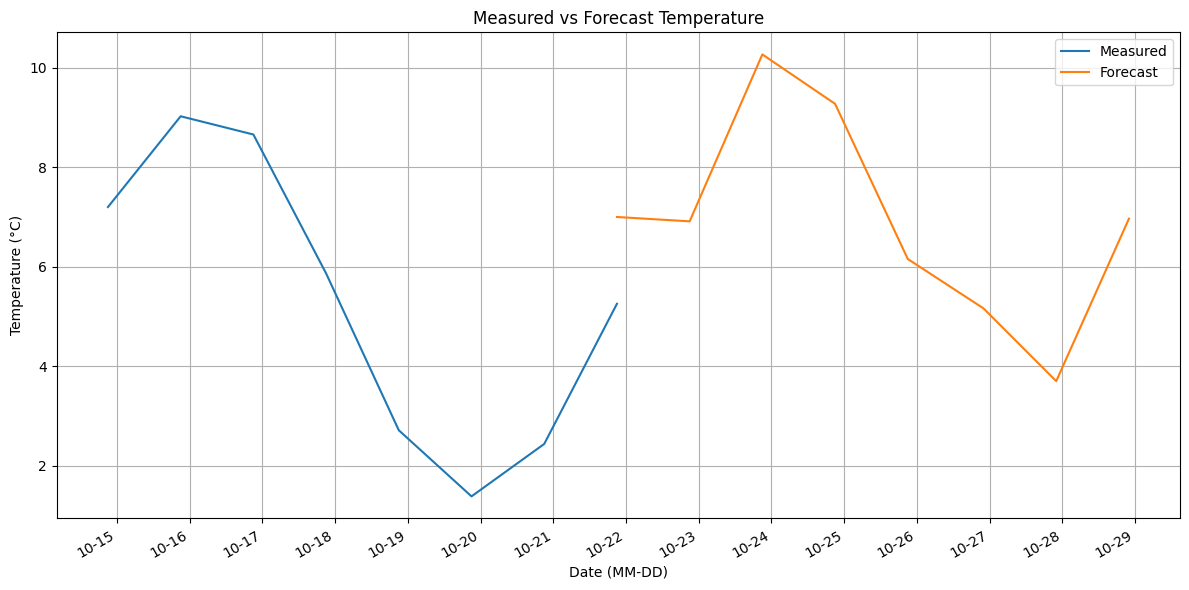

In [ ]:
# Pervadiname stulpelius, kad būtų aišku iš kur duomenys
forecastDataWeek = forecastData.rename(columns={'airTemperature': 'forecastTemperature'})
historicalDataWeek = historicalData.rename(columns={'airTemperature': 'historicalTemperature'})

# Gauname paskutines 7 dienas istorinių duomenų
lastWeek = historicalDataWeek.last('7D')
lastWeek

# Sujungiame duomenis
combined = pd.concat([
    lastWeek['historicalTemperature'],
    forecastDataWeek['forecastTemperature']
])

# Sukuriame DataFrame su abiem duomenų šaltiniais
combined_df = pd.DataFrame({
    'Historical': lastWeek['historicalTemperature'],
    'Forecast': forecastDataWeek['forecastTemperature']
})

# Pakeičiame duomenis į dieninį dažnį ir apskaičiuojame vidurkius
dailyCombined = combined_df.resample('D').mean()

# Braižome grafiką
plt.figure(figsize=(12,6))
plt.plot(dailyCombined.index, dailyCombined['Historical'], label='Measured')
plt.plot(dailyCombined.index, dailyCombined['Forecast'], label='Forecast')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Temperature (°C)')
plt.title('Measured vs Forecast Temperature')
plt.gca().xaxis.set_major_locator(mdates.DayLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Visi nuskaityti duomenys yra valandiniai. Parašyti funkciją, į kurią padavus temperatūros pandas. Series suskaičiuotų tarpines reikšmes ir pagražintų rezultatą pandas. Series kurio dažnis yra 5 minutės. Tarpines reikšmes interpoliuoti.


In [ ]:
# Funkcija duomenų resamplinimui ir interpoliacijai kas 5 minutes
def resampleAndInterpolate5min(series, days=None):
    # Pasirenkame paskutinius 'days' dienų duomenis
    series= series.last(f'{days}D')
    # Resampliname duomenis kas 5 minutes
    resampled = series.resample('5T').mean()
    # Interpoliuojame trūkstamus duomenis
    interpolated = resampled.interpolate(method='time')
    # Grąžiname interpoliuotus duomenis
    return interpolated

In [ ]:
# Supatoginame naudojimą
temp = historicalData['airTemperature']
# Pasirenkame paskutinius 7 dienų duomenis(galima keisti)
lastDaysCount = 7
# Resampliname ir interpoliujame duomenis kas 5 minutes iškviesdami metodą
resampled = resampleAndInterpolate5min(temp, days=lastDaysCount)
#Atspausdiname duomenis
print(resampled.head(100))
print(resampled.index.freq)

observationTimeUtc
2025-10-15 21:00:00+03:00    7.000
2025-10-15 21:05:00+03:00    7.025
2025-10-15 21:10:00+03:00    7.050
2025-10-15 21:15:00+03:00    7.075
2025-10-15 21:20:00+03:00    7.100
                             ...  
2025-10-16 04:55:00+03:00    7.300
2025-10-16 05:00:00+03:00    7.300
2025-10-16 05:05:00+03:00    7.300
2025-10-16 05:10:00+03:00    7.300
2025-10-16 05:15:00+03:00    7.300
Freq: 5min, Name: airTemperature, Length: 100, dtype: float64
<5 * Minutes>


C:\Users\Home\AppData\Local\Temp\ipykernel_9988\2850094732.py:4: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  series= series.last(f'{days}D')
C:\Users\Home\AppData\Local\Temp\ipykernel_9988\2850094732.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = series.resample('5T').mean()


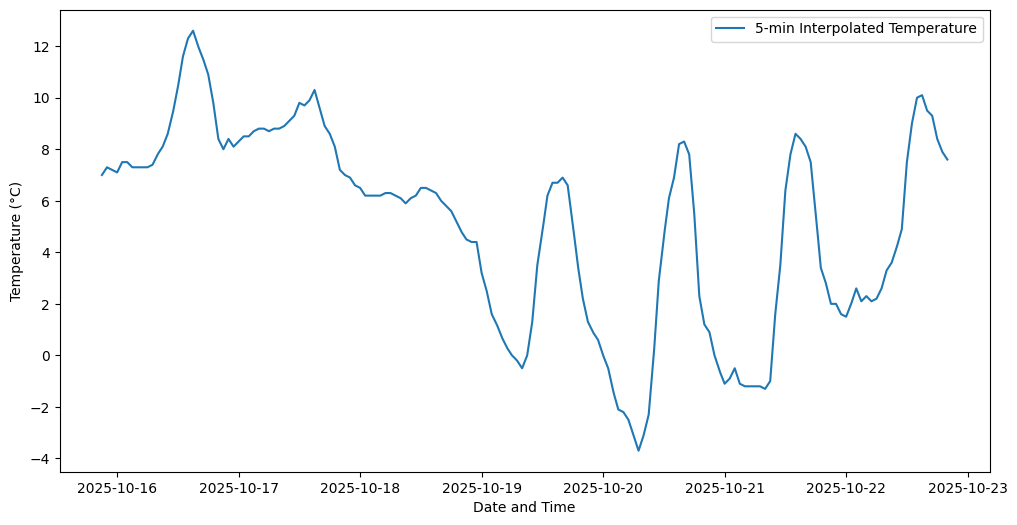

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(resampled.index, resampled.values, label='5-min Interpolated Temperature')
plt.xlabel('Date and Time')
plt.ylabel('Temperature (°C)')
plt.legend()